# Выпускной проект

**A/B-тестирование**

##  Сбор первичной информации о проекте

### Описание проекта

Предоставлен набор данных с действиями пользователей, которые нужно использовать для выявления последствий от внедрения новой улучшенной системы рекомендаций.

### Задачи проекта

Провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Основной проект

### Предобработка данных:

In [1]:
# Add modules to the project
import math as mth
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
from scipy import stats as st
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

# Logical indicator for local and yandex machine
lmachine = 'yandex'
#lmachine = 'local'

In [2]:
# Get common information about datasets
def get_info(df, df_name):
    '''
    Эта функция содержит набор команд для предварительной обработки данных
    df : Dataframe,
        The dataset with data for the project
    df_name : Objects
        The name of the dataset for information
        
    Return:
        There are no return fields
    '''
    print(f'Common information about - {df_name}')
    display(df.head(5))
    print('')
    df.info()
    print('\n', 'Columns name', '\n')
    print(df.columns, '\n')   
    print(f'Numbers of NaN values in the dataset - {df_name}')
    print(df.isnull().sum())
    print('')
    print(f'Numbers of duplicates (explicit)in the dataset - {df_name}')
    print(df.duplicated().sum())
     

# Get data
if lmachine == 'local':
    print('Using local machine')
    main_path = 'C:/Users/Churiulin/Desktop/Yandex/FINAL PROJECT/AB_test_data'
    df_market_events  = pd.read_csv(f'{main_path}/ab_project_marketing_events.csv')
    df_final_users    = pd.read_csv(f'{main_path}/final_ab_new_users.csv'         )
    df_final_events   = pd.read_csv(f'{main_path}/final_ab_events.csv'            )
    df_final_particip = pd.read_csv(f'{main_path}/final_ab_participants.csv'      ) 
else:
    print('Using Yandex machine')
    df_bank   = pd.read_csv('/datasets/bank_dataset.csv')
    df_market_events  = pd.read_csv('/datasets/ab_project_marketing_events.csv'   )
    df_final_users    = pd.read_csv('/datasets/final_ab_new_users.csv'            )
    df_final_events   = pd.read_csv('/datasets/final_ab_events.csv'               )
    df_final_particip = pd.read_csv('/datasets/final_ab_participants.csv'         )

Using Yandex machine


#### Датасет - ab_project_marketing_events:

In [3]:
print(get_info(df_market_events, 'ab_project_marketing_events')) 

Common information about - ab_project_marketing_events


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

 Columns name 

Index(['name', 'regions', 'start_dt', 'finish_dt'], dtype='object') 

Numbers of NaN values in the dataset - ab_project_marketing_events
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Numbers of duplicates (explicit)in the dataset - ab_project_marketing_events
0
None


**Комментарий по датасету - ab_project_marketing_events:**

1. Требуется изменить формат данных в колонках **start_dt** и **finish_dt**. В настоящий момент тип *Objects*, нужный формат *datetime64[ns]*;
2. В стобце **name** представлено 14 уникальных событий, записаных с использование разных регистров, что не является критичным, но лучше все привести к прописным буквам.

In [4]:
# Change type of data
df_market_events['start_dt']  =  df_market_events['start_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
df_market_events['finish_dt'] = df_market_events['finish_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

# Change register
column_list = ['name', 'regions']
for col in column_list:
    df_market_events[col] = df_market_events[col].str.lower() 

Проверим датасет еще раз

In [5]:
print(get_info(df_market_events, 'ab_project_marketing_events')) 

Common information about - ab_project_marketing_events


,name,regions,start_dt,finish_dt
0,christmas&new year promo,"eu, n.america",2020-12-25,2021-01-03
1,st. valentine's day giveaway,"eu, cis, apac, n.america",2020-02-14,2020-02-16
2,st. patric's day promo,"eu, n.america",2020-03-17,2020-03-19
3,easter promo,"eu, cis, apac, n.america",2020-04-12,2020-04-19
4,4th of july promo,n.america,2020-07-04,2020-07-11



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes

 Columns name 

Index(['name', 'regions', 'start_dt', 'finish_dt'], dtype='object') 

Numbers of NaN values in the dataset - ab_project_marketing_events
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Numbers of duplicates (explicit)in the dataset - ab_project_marketing_events
0
None


*Вывод:* Набор данных подготовлен для последующей работы. 

#### Датасет - final_ab_new_users:

In [6]:
print(get_info(df_final_users, 'final_ab_new_users'))

Common information about - final_ab_new_users


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

 Columns name 

Index(['user_id', 'first_date', 'region', 'device'], dtype='object') 

Numbers of NaN values in the dataset - final_ab_new_users
user_id       0
first_date    0
region        0
device        0
dtype: int64

Numbers of duplicates (explicit)in the dataset - final_ab_new_users
0
None


**Комментарий по датасету - final_ab_new_users:**

1. Требуется изменить формат данных в колонках **first_date**. В настоящий момент тип Objects, нужный формат datetime64[ns];
2. Изменить регистр в столбцах **region**,**device**, **user_id**;
3. Убедиться, что запись регионов осуществляется корректно.

In [7]:
# Change type of data
df_final_users['first_date']  =  df_final_users['first_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

# Change register
column_list = ['region', 'device', 'user_id']
for col in column_list:
    df_final_users[col] = df_final_users[col].str.lower() 

# Check unique regions 
print(df_final_users['region'].unique())

['eu' 'n.america' 'apac' 'cis']


Проверим датасет еще раз

In [8]:
print(get_info(df_final_users, 'final_ab_new_users'))

Common information about - final_ab_new_users


,user_id,first_date,region,device
0,d72a72121175d8be,2020-12-07,eu,pc
1,f1c668619dfe6e65,2020-12-07,n.america,android
2,2e1bf1d4c37ea01f,2020-12-07,eu,pc
3,50734a22c0c63768,2020-12-07,eu,iphone
4,e1bddce0dafa2679,2020-12-07,n.america,iphone



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB

 Columns name 

Index(['user_id', 'first_date', 'region', 'device'], dtype='object') 

Numbers of NaN values in the dataset - final_ab_new_users
user_id       0
first_date    0
region        0
device        0
dtype: int64

Numbers of duplicates (explicit)in the dataset - final_ab_new_users
0
None


*Вывод:* Набор данных подготовлен для последующей работы. 

#### Датасет - final_ab_events:

In [9]:
print(get_info(df_final_events, 'final_ab_events')) 

Common information about - final_ab_events


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

 Columns name 

Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object') 

Numbers of NaN values in the dataset - final_ab_events
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Numbers of duplicates (explicit)in the dataset - final_ab_events
0
None


**Комментарий по датасету - final_ab_events:**

1. Изменить регистр в столбцах **user_id**, **event_name**;
2. В данных есть множество пропусков в столбце **details** - пока оставлю без изменения, поскольку корректно заполнить их не представляется возможным: например, в случае значения *login*, который пользователь решил не указывать. Тем не менее, выполню более детальный анализ пропусков для того чтобы посмотреть, насколько ситуация критичная.
3. Требуется изменить формат данных в колонках **event_dt**. В настоящий момент тип *Objects*, нужный формат *datetime64[ns]*;

In [10]:
# Change type of data
df_final_events['event_dt']  =  df_final_events['event_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

# Change register
column_list = ['user_id', 'event_name']
for col in column_list:
    df_final_events[col] = df_final_events[col].str.lower() 

# Check unique event_name 
print(df_final_events['event_name'].unique())

['purchase' 'product_cart' 'product_page' 'login']


Проверим датасет еще раз

In [11]:
print(get_info(df_final_events, 'final_ab_events')) 

Common information about - final_ab_events


,user_id,event_dt,event_name,details
0,e1bddce0dafa2679,2020-12-07 20:22:03,purchase,99.99
1,7b6452f081f49504,2020-12-07 09:22:53,purchase,9.99
2,9cd9f34546df254c,2020-12-07 12:59:29,purchase,4.99
3,96f27a054b191457,2020-12-07 04:02:40,purchase,4.99
4,1fd7660fdf94ca1f,2020-12-07 10:15:09,purchase,4.99



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB

 Columns name 

Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object') 

Numbers of NaN values in the dataset - final_ab_events
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Numbers of duplicates (explicit)in the dataset - final_ab_events
0
None


**Детальный анализ пропусков:**

In [12]:
report = df_final_events.groupby('event_name').agg({'details':'count'})

*Вывод:* Набор данных подготовлен для последующей работы. Наличие пропусков в столбце **details** исправлять не требуется, поскольку достоверно заполнить такую информацию, как логин или продуктовая корзина, не получится без реальных данных. Более того, все покупки, которые совершали пользователи, имеют заполненные значения, что удовлетворяет цели исследования.

#### Датасет - final_ab_participants:

In [13]:
print(get_info(df_final_particip, 'final_ab_participants')) 

Common information about - final_ab_participants


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

 Columns name 

Index(['user_id', 'group', 'ab_test'], dtype='object') 

Numbers of NaN values in the dataset - final_ab_participants
user_id    0
group      0
ab_test    0
dtype: int64

Numbers of duplicates (explicit)in the dataset - final_ab_participants
0
None


**Комментарий по датасету - final_ab_participants:**

1. Изменить регистр в столбцах user_id, group и уточнить значения в столбце **ab_test**;
2. Проверить, что **user_id** не пересекаются в столце **group**.

In [14]:
# Change register
column_list = ['user_id', 'group', 'ab_test']
for col in column_list:
    df_final_particip[col] = df_final_particip[col].str.lower()
    
# Check unique ab_test 
print(df_final_particip['ab_test'].unique())

['recommender_system_test' 'interface_eu_test']


Поиск по уникальным значениям показал, что в датасете представлено два типа тестов: *recommender_system_test* и *interface_eu_test*. Согласно техническому заданию, нас интересует только первый вид теста. Следовательно, лишние данные можно убрать, но сделаю я это немного позже

Проверим датасет еще раз

In [15]:
print(get_info(df_final_particip, 'final_ab_participants'))

Common information about - final_ab_participants


,user_id,group,ab_test
0,d1aba3e2887b6a73,a,recommender_system_test
1,a7a3664bd6242119,a,recommender_system_test
2,dabc14fddfadd29e,a,recommender_system_test
3,04988c5df189632e,a,recommender_system_test
4,482f14783456d21b,b,recommender_system_test



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

 Columns name 

Index(['user_id', 'group', 'ab_test'], dtype='object') 

Numbers of NaN values in the dataset - final_ab_participants
user_id    0
group      0
ab_test    0
dtype: int64

Numbers of duplicates (explicit)in the dataset - final_ab_participants
0
None


Теперь выполню проверку на пересечение пользователей по разным группам.

In [16]:
groupA        = df_final_particip.query('group == "a"')
groupB        = df_final_particip.query('group == "b"') 
unic_visitorA = groupA['user_id'].unique()
unic_visitorB = groupB['user_id'].unique()

user_id_list = []
for id_A in unic_visitorA:
    for id_B in unic_visitorB:
        if id_A == id_B:
            user_id_list.append(id_B)
            
print('Clients in both groups - problem clients:')
print(len(user_id_list))            

Clients in both groups - problem clients:
776


Список проблемных клиентов готов, но количество попавших в него участников довольно большое (776 пользователей), что наталкивает на мысль, что что-то здесь не так. Тем не менее, изучив количество пользователей, можно придти к выводу, что, скорее всего, в обоих тестах в группу Б входили одни и те же пользователи. Поэтому я выполню отдельную проверку только для пользователей из теста `"recommender_system_test"`.

In [17]:
# Check my assamption:
test    = "recommender_system_test"
df_test = df_final_particip.query('ab_test == @test')

# Check again
groupA = df_test.query('group == "a"')['user_id'].unique()
groupB = df_test.query('group == "b"')['user_id'].unique()

# Control run
user_id_list2 = []
for id_A in groupA:
    for id_B in groupB:
        if id_A == id_B:
            user_id_list2.append(id_B)
            
print('Clients in both groups from recommender_system_test:')
print(len(user_id_list2))  

# Check unic users_id
print('')
print('Numbers of unique users in each group:')
print(df_test.query('group == "a"')['user_id'].nunique())
print(df_test.query('group == "b"')['user_id'].nunique())

Clients in both groups from recommender_system_test:
0

Numbers of unique users in each group:
3824
2877


Сделав отдельную выборку только для интересующего нас теста, вышеупомянутое предположение об использовании одной контрольной группы для двух тестов становится более релевантным. Тем не менее, для выяснения истинных причин стоило бы обратиться к поставщику данных для тестов и уточнить эти детали. Кроме того, из анализа данных видно, что количество участников распределенно неравномерно. Участников из группы А примерно на тысячу больше, чем участников из группы Б.

*Вывод:* Набор данных подготовлен для последующей работы. 

###  Анализ данных

#### Подготовка данных под техническое задание:

Для того, чтобы подготовить необходимый для работы набор данных, требуется сделать несколько подготовительных операций:
1. Отобрать только новых пользователей - *<= 2020-12-21*;
2. Использовать только данные из тестового набора - *recommender_system_test*;
3. Регион исследования - *EU*; 
4. Исключить пользователей, присутсвтвующих в обоих группах.

In [18]:
# Create parameters for filters
control_data   = pd.to_datetime('2020-12-21')
control_test   = "recommender_system_test"
control_region = "eu"

# Get new dataframes
df_final_users    = df_final_users.query('first_date <= @control_data')
df_final_particip = df_final_particip.query('ab_test == @control_test')

# Merge - step 1
df_final          = df_final_users.merge(df_final_particip, on = 'user_id', how = 'right')

print(f'Numbers of NaN values in the dataset')
print(df_final.isnull().sum())

Numbers of NaN values in the dataset
user_id       0
first_date    0
region        0
device        0
group         0
ab_test       0
dtype: int64


In [19]:
# Merge - step 2 (old option)
df_final          = df_final.merge(df_final_events        , on = 'user_id', how = 'left' )

print(f'Numbers of NaN values in the dataset')
print(df_final.isnull().sum())

Numbers of NaN values in the dataset
user_id           0
first_date        0
region            0
device            0
group             0
ab_test           0
event_dt       3026
event_name     3026
details       24393
dtype: int64


In [20]:
# Correct values
df_final_eu = df_final.query('region == @control_region')
df_final_eu = df_final_eu.query('user_id not in @user_id_list')
display(df_final_eu)

print(f'Numbers of NaN values in the dataset')
print(df_final_eu.isnull().sum())

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,d1aba3e2887b6a73,2020-12-07,eu,pc,a,recommender_system_test,2020-12-07 14:43:27,purchase,99.99
1,d1aba3e2887b6a73,2020-12-07,eu,pc,a,recommender_system_test,2020-12-25 00:04:56,purchase,4.99
2,d1aba3e2887b6a73,2020-12-07,eu,pc,a,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN
3,d1aba3e2887b6a73,2020-12-07,eu,pc,a,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN
4,d1aba3e2887b6a73,2020-12-07,eu,pc,a,recommender_system_test,2020-12-07 14:43:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
26285,80712ed4ea1b52a5,2020-12-14,eu,android,a,recommender_system_test,2020-12-15 20:10:06,product_page,NaN
26286,80712ed4ea1b52a5,2020-12-14,eu,android,a,recommender_system_test,2020-12-20 20:01:34,product_page,NaN
26287,80712ed4ea1b52a5,2020-12-14,eu,android,a,recommender_system_test,2020-12-14 05:48:50,login,NaN
26288,80712ed4ea1b52a5,2020-12-14,eu,android,a,recommender_system_test,2020-12-15 20:10:03,login,NaN


Numbers of NaN values in the dataset
user_id           0
first_date        0
region            0
device            0
group             0
ab_test           0
event_dt       2535
event_name     2535
details       20344
dtype: int64


Вывод: Скорее всего пропуски в колонках *event_dt* и *event_name* означают, что пользователю была отправлена рекомендация, но он по каким-то причинам даже ее не открыл.

Теперь набор данных является полностью готовым для работы, но, прежде чем приступить, проверю еще распределение пользователей по группам.

#### Проверка набора данных на соответствие требования ТЗ по объему выборки

In [22]:
groupA        = df_final_eu.query('group == "a"')
groupB        = df_final_eu.query('group == "b"')

print('Numbers of unique users in each group:')
print(groupA['user_id'].nunique())
print(groupB['user_id'].nunique())

Numbers of unique users in each group:
3195
2380


*Вывод:* Пользователи по группа распределены неравномерно, что уже является плохим сигналом для анализа А/В теста.

Теперь выполню проверку требования технического задания о 15% пользователей в исходной выборке и подготовленной:
1. Посчитаю общее количество новых пользователей по регионам в исходном наборе данных и данных после выборки интересующего нас теста.

In [23]:
# Get original users
users_report = (df_final_users
                    .groupby(['region'])
                    .agg({'user_id':'count'})
                    .reset_index()
                    .sort_values(by = 'region')
               )
users_report.columns = ['region', 'all_users']

# Get new users
users_report2 = (df_final
                     .groupby(['region'])
                     .agg({'user_id':'nunique'})
                     .reset_index()
                     .sort_values(by = 'region')
                )

users_report2.columns = ['region', 'new_users']
users_report2

# Merge reports
freport = users_report.merge(users_report2,  on = 'region', how = 'left' )
freport['% users'] = (freport['new_users'] / freport['all_users'] * 100).round(1)
freport

,region,all_users,new_users,% users
0,apac,2883,72,2.5
1,cis,2900,55,1.9
2,eu,42340,6351,15.0
3,n.america,8347,223,2.7


*Вывод:* Количество участников из региона EU в исходной выборке с перекликающимся user_id равно 15%, что подтверждает требование ТЗ.

2. Посчитаю общее количество новых пользователей по EU в подготовленном наборе данных.

In [24]:
# Get original users
users_report_eu = users_report.query('region == "eu"')
#users_report_eu

# Get new users
users_report2 = (df_final_eu
                     .groupby(['region'])
                     .agg({'user_id':'nunique'})
                     .reset_index()
                     .sort_values(by = 'region')
                )

users_report2.columns = ['region', 'new_users']

# Merge reports
freport = users_report_eu.merge(users_report2,  on = 'region', how = 'left' )
freport['% users'] = (freport['new_users'] / freport['all_users'] * 100).round(1)
freport

,region,all_users,new_users,% users
0,eu,42340,5575,13.2


**Вывод:** Количество участников из региона EU в подготовленном наборе данных равно 13.2%, что протеворечит требованию ТЗ, но с учетом того, что из данного набора данных исключены перекликающиеся пользователи, скорее всего, это ошибка в ТЗ.

#### Проверка набора данных на соответствие требования ТЗ по дате начала и оканчания эксперимента

In [25]:
# Settings for plots
def plot_settings(ax, title, xlabel, ylabel, deg):                    
    
    ''' 
    Function with setting for plots
    ax             - Figure
        Area for visualization
    title          - Objects
        The plot title
    xlabel, ylabel - Objects
        labels of x and y axis
    deg            - Int
    '''  
    ax.set_title(title  , color = 'black', fontsize = 14, pad = 20)
    ax.set_xlabel(xlabel, color = 'black', fontsize = 14, labelpad = 20)
    ax.set_ylabel(ylabel, color = 'black', fontsize = 14, labelpad = 20)
    
    ax.set_xticks(np.arange(5, 30.1, 1))
    
    ax.grid(True, which     = 'major', 
                  color     = 'k'    ,
                  linestyle = 'solid',
                  alpha     = 0.5    )

    for label in ax.xaxis.get_ticklabels():
        label.set_color('black')
        label.set_rotation(deg)
        label.set_fontsize(14)
    for label in ax.yaxis.get_ticklabels():
        label.set_color('black')
        label.set_fontsize(14)  
    plt.show();   

In [26]:
def get_date_info(df, group):
    '''
    Function for analysis of timeranges
    df : DateFrame
        Research data
    group : Objects
        Research group
    Return
    report : DataFrame
        dataset with information about users per day
    '''
    df_new = df
    # Get min and max data for analysis.
    min_date = df_new['event_dt'].min()
    max_date = df_new['event_dt'].max() 

    # Print info
    print('Самая раняя   дата совершения события:', min_date)
    print('Самая поздняя дата совершения события:', max_date)
    
    df_new['day'] = df_new['event_dt'].dt.day
    
    # Get data collected by date
    report = df_new.groupby('day').agg({'event_dt': 'count'})# .count()
      
    # Plot histogramm
    fig = plt.figure(figsize = (12, 7))
    ax  = fig.add_subplot(111) 

    # visualization
    ax.plot(report.index, report['event_dt'], color = 'blue')
    # plot settings
    plots =  plot_settings(ax, 
                           f'Распределение информации о пользователях по дате поступления сведений - группа {group}',
                           'Номер дня в декабря 2020', 'Количество пользователей',   deg = 0)
  
    plt.show()
    
    return report

Самая раняя   дата совершения события: 2020-12-07 00:16:00
Самая поздняя дата совершения события: 2020-12-29 23:38:29


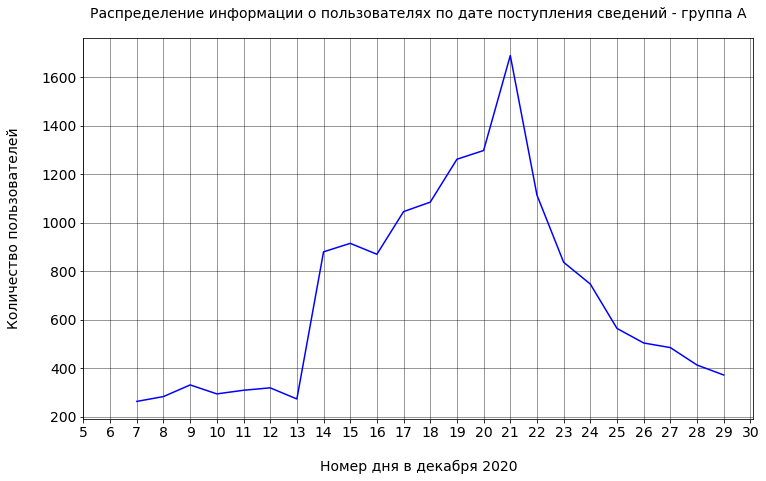

In [27]:
# Check group A
actions_groupA = get_date_info(groupA, "A")

Самая раняя   дата совершения события: 2020-12-07 00:25:02
Самая поздняя дата совершения события: 2020-12-30 06:42:52


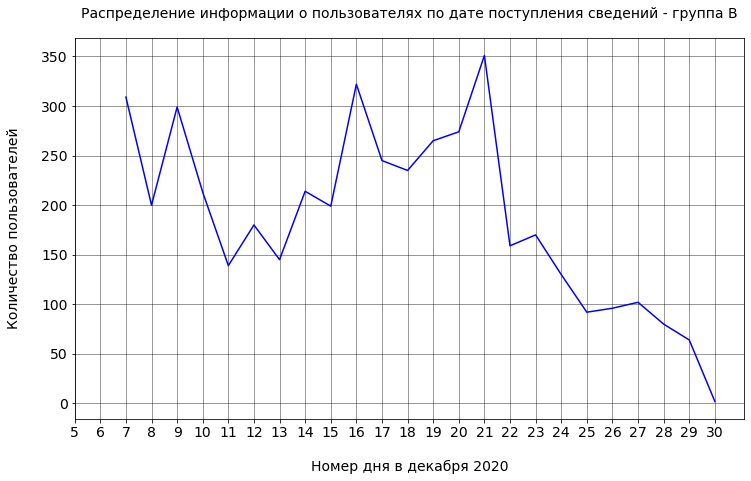

In [28]:
# Check group B
actions_groupB = get_date_info(groupB, "B")

In [29]:
freport = actions_groupA.merge(actions_groupB, on = 'day', how = 'outer')
freport.columns = ['groupA_events', 'groupB_events']
freport

,groupA_events,groupB_events
day,,
7.0,263.0,309
8.0,283.0,200
9.0,331.0,299
10.0,294.0,213
11.0,309.0,139
12.0,319.0,180
13.0,273.0,145
14.0,880.0,214
15.0,915.0,199


**Вывод:** Согслано ТЗ, последний день остановки теста `2021-01-04`, но, по факту, последние действия в группе А были `2020-12-29`, в группе B - `2020-12-30`, что не соответствует ТЗ.

#### Количество действий совершаемых пользователями

Количество уникальных пользователей:

In [30]:
print('Всего уникальных пользователей  - группа А:', groupA['user_id'].nunique())
print('Всего уникальных пользователей  - группа B:', groupB['user_id'].nunique())

Всего уникальных пользователей  - группа А: 3195
Всего уникальных пользователей  - группа B: 2380


Для ответа на вопрос, сколько в среднем событий приходится по группам на одного пользователя, воспользуюсь группировкой и методом groupby:

In [31]:
def get_users(df, group):
    '''
    df : DataFrame
        Data for research
    group: Objects
        Group of test
    Return
    mean_users : DataFrame
        Results of function
    '''
    mean_user = (df
                  .query('group ==@group')  
                  .groupby('user_id')
                  .agg({'event_dt':'count'})
                  .rename(columns = {'event_dt' : 'mean_event'})
                  .sort_values('mean_event', ascending = False)
                 ).reset_index()    
    
    # Users ID for excluding
    top10_list = mean_user.head(10)
    print(f'Research group {group}:')
    print('')
    print("Top users actions:")   
    print(top10_list)
    print('')
    return mean_user
    
# Get data
mean_users_A = get_users(df_final_eu, "a") 
mean_users_B = get_users(df_final_eu, "b") 

Research group a:

Top users actions:
            user_id  mean_event
0  ced71698585a2e46          24
1  1bfee479308eff44          24
2  6e3df9c69a6b607e          21
3  b8ef6f0325a9979f          21
4  4b159898de46ac3a          20
5  109fe65ee47113c9          20
6  f9d53f0ba957f728          20
7  77fc0e20aeac1506          20
8  e20504d0cad45af3          20
9  a2db18f90d9e3362          20

Research group b:

Top users actions:
            user_id  mean_event
0  1198061f6af34b7b          28
1  115ebc1ca027854a          27
2  89545c7f903dba34          21
3  2c2be85372033f77          20
4  4efb5e89ac11ac6d          20
5  7e8720db6a21cf66          20
6  fe76759fe6bf8c68          20
7  b0244412983000c5          18
8  c8460ff8bef553a4          18
9  c48127e2fa8d4f18          18



*Вывод:* 
* В группе А - 10 самых активных пользователей совершают от 20 до 24 активных действий.
* В группе B - 10 самых активных пользователей совершают от 18 до 28 активных действий.

Теперь, когда я знаю, сколько действий приходится на пользователей, построю гистограмму рассеивания, чтобы посмотреть как в целом распределены действия пользователей.

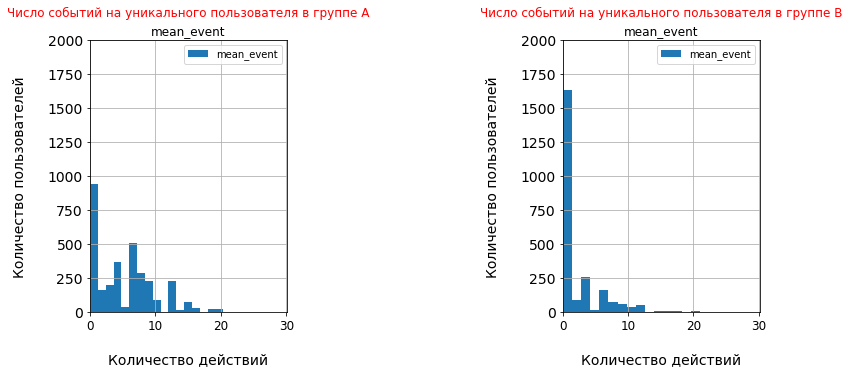

In [32]:
# Function for histogramm
def histogram(df, col, bin, ax, **kwargs):
    return df.plot(y    = col   , title = col,
                   kind = 'hist', bins  = bin,
                   ax   = ax    , **kwargs   )

# Get figure area
fig = plt.figure(figsize = (12,5))

# Сетка состоит из 1 строки и 4 столбцов.
egrid = (1,3)
ax1 = plt.subplot2grid(egrid, (0, 0), colspan=1)
ax2 = plt.subplot2grid(egrid, (0, 2), colspan=1)

# Start visualization
for i, ax in enumerate(fig.axes):
    if i == 0:
        mean_users = mean_users_A # data for group A
        plot_name  = 'Число событий на уникального пользователя в группе А'
    else:
        mean_users = mean_users_B # data for group B
        plot_name  = 'Число событий на уникального пользователя в группе B'
        
    ylabel = 'Количество пользователей' 
    xlabel = 'Количество действий'
    
    # Create plot
    histogram(mean_users  , 'mean_event',                   
              bin  = 20   , ax   = ax   ,
              xlim = (0.0 ,   30.1)     ,
              ylim = (0.0 ,  2000.1)     )

 
    # Add plot title
    ax.text(0.5, 1.1, f'{plot_name}'    ,                
                va        = 'center'    , 
                ha        = 'center'    , 
                color     = 'red'       ,
                fontsize  = 12          ,
                transform = ax.transAxes)
    
    # Labels for axis
    ax.set_ylabel(ylabel, color = 'black', fontsize = 14, labelpad = 20)
    ax.set_xlabel(xlabel, color = 'black', fontsize = 14, labelpad = 20)
    
    # Grid
    ax.grid(True)    
 
    # Settings for axis
    for label in ax.xaxis.get_ticklabels():
                label.set_color('black')
                label.set_rotation(0)
                label.set_fontsize(12)
                
    for label in ax.yaxis.get_ticklabels():
        label.set_color('black')
        label.set_fontsize(14)  
plt.show()

*Вывод:* Большинство пользователей совершают от 1 до 2 действия, после чего прекращают свою деятельность, что выглядит на первый взгляд не очень эффективным. Дополнительно посмотрю на выбросы.

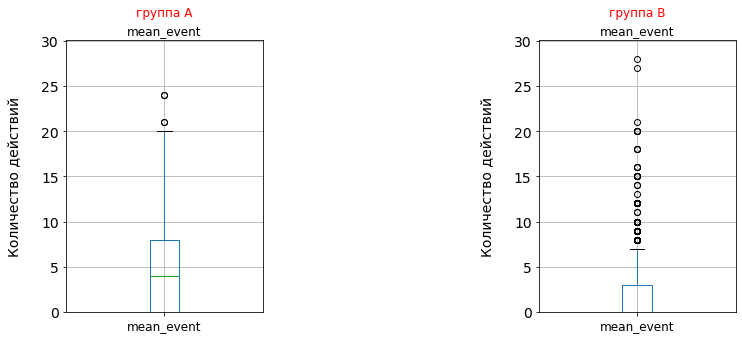

In [33]:
# Create boxplot
def boxplots(df, col, ax, **kwargs):
    return df.plot(y    = col  , title = col, 
                   kind = 'box', ax    = ax ,
                   grid = True , **kwargs   ) 

# Get figure area
fig = plt.figure(figsize = (12,5))

# Сетка состоит из 1 строки и 4 столбцов.
egrid = (1,3)
ax1 = plt.subplot2grid(egrid, (0, 0), colspan=1)
ax2 = plt.subplot2grid(egrid, (0, 2), colspan=1)

# Start visualization
for i, ax in enumerate(fig.axes):
    if i == 0:
        mean_users = mean_users_A # data for group A
        plot_name  = 'группа А'
    else:
        mean_users = mean_users_B # data for group B
        plot_name  = 'группа B'
        
    ylabel = 'Количество действий' 
   
    # Create plot
    boxplots(mean_users, 'mean_event'      ,                   
             ax = ax   , ylim = (0.0, 30.1))
 
    # Add plot title
    ax.text(0.5, 1.1, f'{plot_name}'    ,                
                va        = 'center'    , 
                ha        = 'center'    , 
                color     = 'red'       ,
                fontsize  = 12          ,
                transform = ax.transAxes)
    
    # Labels for axis
    ax.set_ylabel(ylabel, color = 'black', fontsize = 14, labelpad = 20)
    
    # Grid
    ax.grid(True)    
 
    # Settings for axis
    for label in ax.xaxis.get_ticklabels():
                label.set_color('black')
                label.set_rotation(0)
                label.set_fontsize(12)               
    for label in ax.yaxis.get_ticklabels():
        label.set_color('black')
        label.set_fontsize(14)  
plt.show()

**Вывод:**  В среднем пользователи совершают 1-3 действия, после чего прекращают деятельность или просмотр рекомендации, что выглядит подозрительно. Зафиксировать существенную разницу между действиям пользователей в разных группа не удалось. Соответственно, нет особой пользы от внедрения новой системы рекомендаций.

#### Изучение воронки событий

Для того, чтобы ответить на вопрос, сколько всего событий в логе, сначала нужно определить, что же такое событие. Я предполагаю, что событие - есть каждая уникальная строчка в столбце **event_name**. Поэтому нужно найти уникальные значения и посчитать их количество в разных группах:

In [34]:
def event_groups(df):
    '''
    Функция, содержит набор команд для получения событий в логах, их названий и количество.
    df : DataFrame
        data for analysis 
        
    Return
    df_out : DataFrame
        Data collected information about events
    '''
    print('Всего событий в логе - группа А:'     , (df['event_name'].nunique()), '\n')
    print('Уникальные события в логе - группа А:', (df['event_name'].unique()) , '\n')

    event_count = (df
                    .groupby('event_name')
                    .agg({'user_id' : 'count'})
                    .reset_index()
                    .rename(columns = {'user_id' : 'event_numbers'})
                    .sort_values('event_numbers', ascending = False)
                  ).reset_index(drop = True).reindex([0,1,3,2]).reset_index(drop = True)
    return event_count

# Get information about events in 2 groups
event_countA = event_groups(groupA)
display(event_countA)

event_countB = event_groups(groupB)
display(event_countB)

Всего событий в логе - группа А: 4 

Уникальные события в логе - группа А: ['purchase' 'product_cart' 'product_page' 'login' nan] 



,event_name,event_numbers
0,login,7160
1,product_page,4606
2,product_cart,2148
3,purchase,2240


Всего событий в логе - группа А: 4 

Уникальные события в логе - группа А: [nan 'product_page' 'login' 'purchase' 'product_cart'] 



,event_name,event_numbers
0,login,2148
1,product_page,1163
2,product_cart,584
3,purchase,590


*Вывод:*  Большего всего пользователи встречаются с появлением события *login*. Примерно 1/2 от общего числа событий переходит на следующий шаг *product_page*. Этот шаг стоит отметить отдельно по нескольким причинам:

1. Скорее всего, пользователи на этом шаге могут сразу добавить товар в корзину и, исключив дополнительный шаг - *product_cart*, сразу перейти к оплате. Это подтверждается большим количество уникальных событий в строке *purchase*.
2. Из-за такой структуры приложения или сайта, шаг с посещением корзины становится необязательным, и ряд пользователей его минуют. Это также подтверждается данными: значения на шаге *product_cart* меньше, чем на шаге *purchase*.

Отмечу также, что мне не удалось выявить существенной разницы в поведении числа событий из двух групп.

Теперь посмотрим, сколько всего пользователей и рассчитаем конверсию

In [35]:
def users_group(df):
    '''
    Функция содержит набор команд для расчета конверсии пользователей
    df : DataFrame
        Data for analysis
        
    users_count : DataFrame
        information about users conversion
    '''
    users_count = (df
                    .groupby('event_name')
                    .agg({'user_id': 'nunique'})
                    .sort_values(by = 'user_id', ascending = False)
                    .rename(columns = {'user_id' : 'user_numbers'})
                  ).reset_index().reindex([0,1,3,2]).reset_index(drop = True)

    users_count['CR'] = (users_count['user_numbers'] / df['user_id'].nunique())* 100

    # Create a zero timeseries for converstion in step
    cp_step = pd.Series(np.nan, index = users_count.index) # new event_name with space

    for i in range(len(users_count)):
        if i == 0:
            cp_step[i] = (users_count['user_numbers'][i] / users_count['user_numbers'][i]) * 100
        else:
            cp_step[i] = (users_count['user_numbers'][i] / users_count['user_numbers'][i - 1]) * 100

    users_count['CR_step, %'] = cp_step.round(1)
    
    return users_count

# Get information about events in 2 groups
users_count_A = users_group(groupA)
display(users_count_A)

users_count_B = users_group(groupB)
display(users_count_B)

,event_name,user_numbers,CR,"CR_step, %"
0,login,2279,71.330203,100.0
1,product_page,1476,46.197183,64.8
2,product_cart,686,21.471049,46.5
3,purchase,734,22.973396,107.0


,event_name,user_numbers,CR,"CR_step, %"
0,login,761,31.974790,100.0
1,product_page,431,18.109244,56.6
2,product_cart,214,8.991597,49.7
3,purchase,221,9.285714,103.3


*Вывод:* Рассчитав конверсию на каждом шаге для каждой из групп можно отметить, что ни на одном шаге нет 100 %, поскольку ни один пункт не является объязательным. Кроме того, рассчитанные значения подтверждают выдвинутое ранее предположение о том, что шаг *product_cart* является необъязательным и может быть удален.

Также значения в столбце *CR_step, %* (конверсия в шаг) равное 107% и 103% означают, что пользователи могут перейти к стадии покупки, как со страницы *	product_page*, так и *product_cart*.

Соединю итоговые таблицы для формирования результата

In [36]:
reportA = event_countA.merge(users_count_A, on = ['event_name'], how = 'left')
reportB = event_countB.merge(users_count_B, on = ['event_name'], how = 'left')

print('Full report - group A')
display(reportA)

print('Full report - group B')
display(reportB)

Full report - group A


,event_name,event_numbers,user_numbers,CR,"CR_step, %"
0,login,7160,2279,71.330203,100.0
1,product_page,4606,1476,46.197183,64.8
2,product_cart,2148,686,21.471049,46.5
3,purchase,2240,734,22.973396,107.0


Full report - group B


,event_name,event_numbers,user_numbers,CR,"CR_step, %"
0,login,2148,761,31.974790,100.0
1,product_page,1163,431,18.109244,56.6
2,product_cart,584,214,8.991597,49.7
3,purchase,590,221,9.285714,103.3


Построю воронки событий

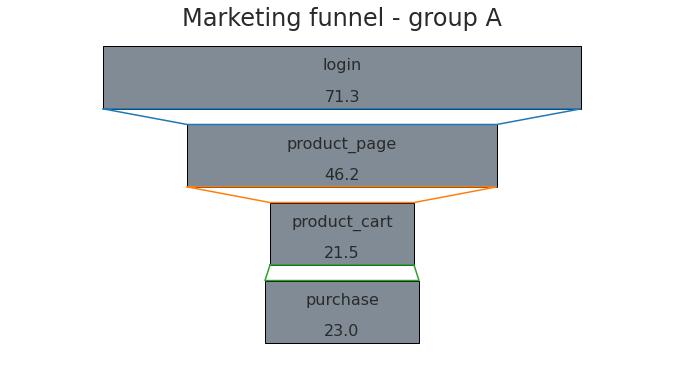

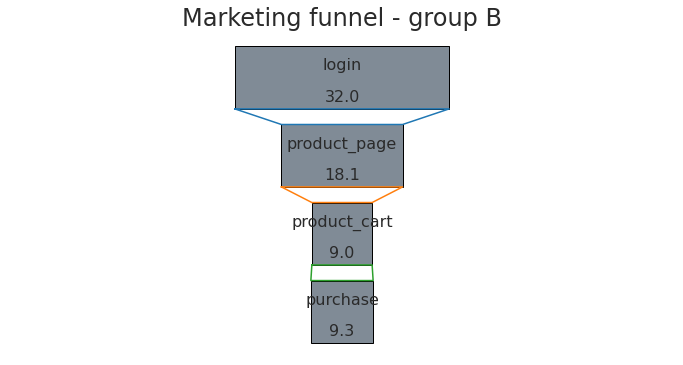

In [37]:
def get_funnel(x, y, labels, group_name):
    '''
    Function for visualization of marketing funnel
    x : Int
        Numbers of events in funnel
    y : Float
        % of conversion
    labels : Objects
        Names of events
    group_name : Obgects
        Title for funnel
    '''
    
    x_max = 100
    x_min = 0
    x_range = x_max - x_min

    fig, ax = plt.subplots(1, figsize=(12,6))
    for idx, val in enumerate(x):
        left = (x_range - val)/2
        plt.barh(y[idx], x[idx], left      = left     , 
                                 color     = '#808B96',
                                 height    = 0.8      , 
                                 edgecolor = 'black'  )
        # label
        plt.text(50, y[idx]+0.1, labels[idx], ha       = 'center' ,
                                              fontsize = 16       ,
                                              color    = '#2A2A2A')
        # value
        plt.text(50, y[idx]-0.3, x[idx], ha       = 'center' , 
                                         fontsize = 16       ,
                                         color    = '#2A2A2A')

        if idx != len(x)-1:
            next_left = (x_range - x[idx + 1]) / 2
            shadow_x  = [left, next_left, 
                         100 - next_left, 100 - left, left]

            shadow_y  = [y[idx] - 0.4    , y[idx + 1] + 0.4, 
                         y[idx + 1] + 0.4, y[idx] - 0.4, y[idx] - 0.4]
            plt.plot(shadow_x, shadow_y)
    plt.xlim(x_min, x_max)
    plt.axis('off')
    plt.title(group_name, loc = 'center', fontsize = 24, color = '#2A2A2A')
    plt.show()
    
    
# Get data for funnel 
y      = [4, 3  ,  2  ,  1  ]

# Group A
x1      = reportA['CR'].round(1)
labels1 = reportA['event_name']
get_funnel(x1, y, labels1, 'Marketing funnel - group A')

# Group B
x2      = reportB['CR'].round(1)
labels2 = reportB['event_name']
get_funnel(x2, y, labels2, 'Marketing funnel - group B')  

*Вывод:* Только половина пользователей совершают покупку, при этом ожидаемого повышения покупательской способности с вводом новой системы рекомендаций выявить не удалось.

#### Изучение результатов экспериментов:

In [38]:
group_members = (df_final_eu.groupby('group')
                            .agg({'user_id':'nunique'})
                            .rename(columns = {'user_id': 'users'})
                            .reset_index()
                )

group_members['users %'] = ((group_members['users'] / df_final_eu['user_id'].nunique()) * 100).round(1)
group_members

,group,users,users %
0,a,3195,57.3
1,b,2380,42.7


Вывод: Количество участников в каждой группе абсолютно разное. В контрольной группe, использующей старую систему рекомендаций, количество участников 3195 (57.3%). В экспериментальную группу попало намного меньше участников - 2380 (42.7%). На мой взгляд, такой распределение не является эффективным, поскольку превалирующее количество участников в одной группе может привести к дибалансу эксперимента и провалу теста. Кроме того, в результате такого теста мы можем получить недостоверные результаты.

#### A/B тест

In [39]:
# Function for calculation of conversion for each group
def get_group_conversion(df):
    '''
    df - DataFrame
        The data from the research group
    return: funnel - DataFrame
    
    '''
    funnel = (df
               .groupby('event_name')
               .agg({'user_id': 'nunique'})
               .sort_values(by = 'user_id', ascending = False)
               .rename(columns = {'user_id' : 'user_numbers'})
             ).reset_index()

    funnel['tot_users'] = df['user_id'].nunique()
    funnel['CR']        = (funnel['user_numbers'] / funnel['tot_users'])* 100
    return funnel

In [40]:
# Function for calculation of z-tests
def get_z_test(df1, df2, alpha, event):
    '''
    df1 - DataFrame
        The first group data
    df2 - DataFrame
        The second group data
    alpha - Float
       критический уровень статистической значимости 
    event - Objects
        the name of the event
    '''
    # Numbers of people in each step
    successes = np.array([df1.loc[df1.loc[:, 'event_name'] == event]['user_numbers'].values,
                          df2.loc[df2.loc[:, 'event_name'] == event]['user_numbers'].values])

    # Total numbers
    trials    = np.array([df1.loc[df1.loc[:, 'event_name'] == event]['tot_users'].values,
                          df2.loc[df2.loc[:, 'event_name'] == event]['tot_users'].values])

    # пропорция успехов в первой и второй группе:
    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]
    

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))

    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    # считаем p_value
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

Изучим, изменилось ли что-то после внедрения новой системы рекомендаций или все осталось примерно также. Кроме того, проверим, есть ли разница между группами по статистическим критериям и разница между группой для исследования и контрольной группой. 

1. **z - тест**

Определим конверсии для каждой из групп для того, чтобы выполнить проверку с использованием **z теста**. 

In [41]:
# Get funnel for group A
funnel_A = get_group_conversion(groupA)
print('Control group A')
funnel_A

Control group A


,event_name,user_numbers,tot_users,CR
0,login,2279,3195,71.330203
1,product_page,1476,3195,46.197183
2,purchase,734,3195,22.973396
3,product_cart,686,3195,21.471049


In [42]:
# Get funnel for group B
funnel_B = get_group_conversion(groupB)
print('Control group B')
funnel_B

Control group B


,event_name,user_numbers,tot_users,CR
0,login,761,2380,31.974790
1,product_page,431,2380,18.109244
2,purchase,221,2380,9.285714
3,product_cart,214,2380,8.991597


Проверим равенство пропорций для первой и второй контрольной группы:

**Нулевая гипотеза:** Доля клиентов, посетивших главную страницу приложения (страницу предложений, выполнивших оплату), из контрольной группы A равна доле клиентов из контрольной группы B. **Альтернативная гипотеза:** пропорция одной из групп больше или меньше другой.

In [43]:
# login
get_z_test(funnel_A, funnel_B, 0.05, 'login'       )
# product_page
get_z_test(funnel_A, funnel_B, 0.05, 'product_page')
# product_cart
get_z_test(funnel_A, funnel_B, 0.05, 'product_cart')
# purchase
get_z_test(funnel_A, funnel_B, 0.05, 'purchase'    )

p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод:** На основании *z теста* удалось установить, что нет разницы между пропорциями контрольных групп A и B по 3 из четырех событий. Разницу удалось зафиксировать только для события **product_page**.

Дополнительно выполню проверку на ложнопозитивный результат. У нас есть 4 гипотезы, которые я проверяю. Соответственно из формулы:
![Bof](https://pictures.s3.yandex.net/resources/Untitled-f33fc295-f007-4b31-b2dd-89ee237989d1_1569201056.png)

я получаю 0.05 / 4 = 0.0125. Соответственно, я должен понизить уровень значимости, чтобы исключить эффект ложнопозитивного результата при множественном тестировании гипотез.

In [44]:
# login
get_z_test(funnel_A, funnel_B, 0.0125, 'login'       )
# product_page
get_z_test(funnel_A, funnel_B, 0.0125, 'product_page')
# product_cart
get_z_test(funnel_A, funnel_B, 0.0125, 'product_cart')
# purchase
get_z_test(funnel_A, funnel_B, 0.0125, 'purchase'    )

p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница


Теперь, скорректировав уровень значимости, я могу с уверенностью сказать, что нет особой разницы между пользователями, использующими новую и старую системы рекомендаций для посещения главной страницы приложения и оплативших ее.

## Общий вывод по работе

В результате анализа данных было установлено, что внедрение новой системы рекомендаций никак не влияет на количество посещений клиентами приложения. Наибольшее количество клиентов уходит после посещения главной страницы и не переходит к дальнейшим покупкам. Со страницы выбора продуктов только 50% совершают покупки, что является не очень эффективным.

Соответственно, в качестве рекоммендации можно предположить, что проблема не в системе рекомендаций, а, скажем, в шрифтах страниц приложения или неудобной системе оплаты и т.д. Это требует дальнейшего анализа, кроме того, для более качественных результатов нужно использовать равномерное распределение пользователей по контрольным группам.

На данном этапе тест можно завершить. Отдельно отмечу, что часть данных, полученных в работе, не соответствует изначально поставленному техническому заданию.
1. Ожидаемое количество участников теста: 6000. По факту имеем 5575 пользователей;
2. Доля новых пользователей 13.2% вместо заявленых 15%;
3. Дата остановки теста согласно ТЗ: `2021-01-04`; По факту последняя активность в **группе А** зафиксированна `2020-12-29`, а в **группе В** `2020-12-30`.